In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import requests
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import matplotlib.pyplot as plt

In [3]:
# Veri setini yükle
#data_path = "/phishing_site_urls.csv"
#df = pd.read_csv(data_path)
df = pd.read_csv(r'drive/MyDrive/phishing_site_urls.csv')

In [4]:
df.shape

(549346, 2)

<BarContainer object of 2 artists>

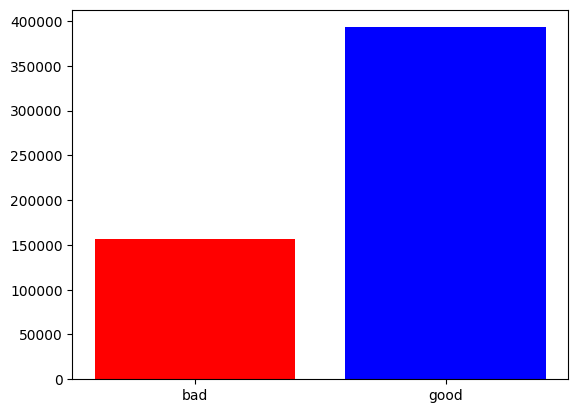

In [5]:
x=df.Label.unique()
y=np.array([df[df['Label']=='bad'].count()[0],df[df['Label']=='good'].count()[0]])
plt.bar(x,y,color=[ 'red', 'blue'])

In [6]:
df[df['Label']=='bad'].count()

URL      156422
Label    156422
dtype: int64

In [7]:
df[df['Label']=='good'].count()

URL      392924
Label    392924
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [9]:
df.isna().sum()

URL      0
Label    0
dtype: int64

In [10]:
df.URL.duplicated().sum()

42151

In [11]:
df = df.drop_duplicates()

In [12]:
df.describe()

,URL,Label
count,507196,507196
unique,507195,2
top,tommyhumphreys.com/,good
freq,2,392897


In [13]:
df[df['Label']=='bad'].count()

URL      114299
Label    114299
dtype: int64

In [14]:
df[df['Label']=='good'].count()

URL      392897
Label    392897
dtype: int64

In [15]:
# Gerekli sütunları ve etiketleri seçme
X = df['URL']
y = df['Label']

In [16]:
# Metinleri vektörlere dönüştürme
tokenizer = Tokenizer(num_words=10000)  # Kelime sayısını sınırlar
#tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X = pad_sequences(sequences, maxlen=100)

In [17]:
# Etiketleri kategorik hale getirme
y = pd.get_dummies(y)

In [18]:
# Eğitim ve test verilerini ayırma
split = int(0.8 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [19]:
# Sinir ağı modelini oluşturma
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=100))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [20]:
# Early stopping kullanarak eğitimi durdurma
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [21]:
checkpointer = ModelCheckpoint(filepath=f'best_model_phishingDetection.hdf5',
                                    verbose=1, save_best_only=True)
csv_logger = CSVLogger(f'history_phishingDetection.log')

In [22]:
# Modeli eğitme
history = model.fit(X_train,
                    y_train,
                    batch_size=64,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    callbacks=[csv_logger, checkpointer])

model.save(f'model_trained_nn.hdf5')

Epoch 1/10
6339/6340 [============================>.] - ETA: 0s - loss: 0.1283 - accuracy: 0.9579
Epoch 1: val_loss improved from inf to 0.42374, saving model to best_model_phishingDetection.hdf5
6340/6340 [==============================] - 211s 31ms/step - loss: 0.1282 - accuracy: 0.9579 - val_loss: 0.4237 - val_accuracy: 0.8393
Epoch 2/10
6339/6340 [============================>.] - ETA: 0s - loss: 0.1019 - accuracy: 0.9671
Epoch 2: val_loss improved from 0.42374 to 0.40102, saving model to best_model_phishingDetection.hdf5
6340/6340 [==============================] - 175s 28ms/step - loss: 0.1019 - accuracy: 0.9671 - val_loss: 0.4010 - val_accuracy: 0.8371
Epoch 3/10
6339/6340 [============================>.] - ETA: 0s - loss: 0.0954 - accuracy: 0.9694
Epoch 3: val_loss did not improve from 0.40102
6340/6340 [==============================] - 172s 27ms/step - loss: 0.0954 - accuracy: 0.9694 - val_loss: 0.4013 - val_accuracy: 0.8450
Epoch 4/10
6340/6340 [=============================

In [23]:
# Eğitim sürecindeki doğruluk ve kayıp değerlerini alın
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
test_loss = history.history['val_loss']

loss, accuracy = model.evaluate(X_test, y_test)
# Elde edilen sonuçları yazdırın
print('Test Kayıp Değeri:', loss)
print('Test Doğruluk Değeri:', accuracy)
#print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
#print(f"Train Loss: {train_loss:.4f}")
#print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

3170/3170 [==============================] - 28s 8ms/step - loss: 0.3864 - accuracy: 0.8653
Test Kayıp Değeri: 0.3863901197910309
Test Doğruluk Değeri: 0.8652701377868652


In [24]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()

def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

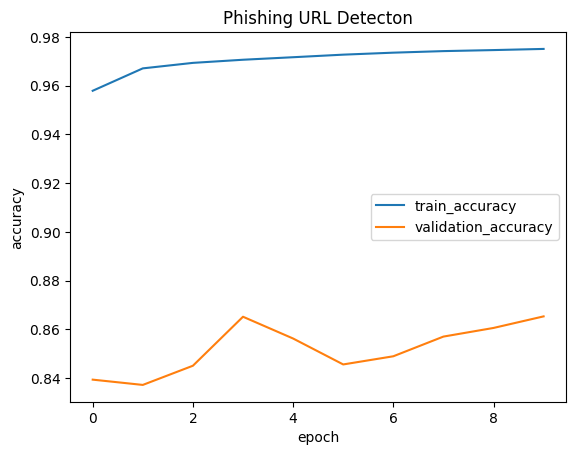

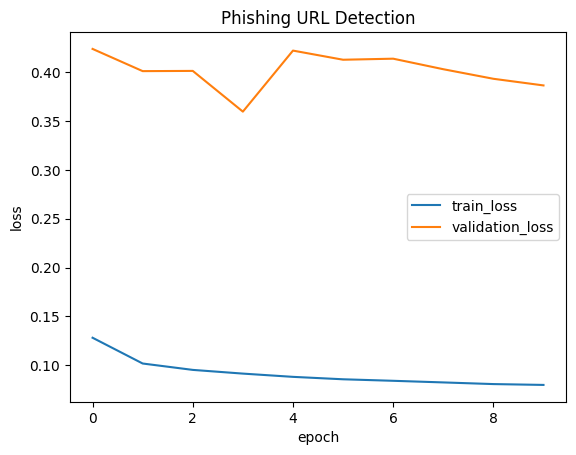

In [25]:
plot_accuracy(history,'Phishing URL Detecton')
plot_loss(history,'Phishing URL Detection')

In [26]:
def oltalama_tespiti(url):
    # URL'yi içeriği almak için istek gönder
    response = requests.get(url)
    content = response.text

    # URL içeriğini diziye dönüştürme
    content_list = [content]

    # Metinleri vektörlere dönüştürme
    sequences = tokenizer.texts_to_sequences(content_list)
    padded_sequences = pad_sequences(sequences, maxlen=100)

    # Modeli kullanarak tahmin yapma
    prediction = model.predict(padded_sequences)

    # Tahmini yorumlama
    if np.argmax(prediction[0]) == 1:
        return "Bu bir oltalama sitesidir."
    else:
        return "Bu bir oltalama sitesi değildir."



In [27]:
# Test etmek için bir URL kullanın
url = "https://www.example.com"  # İstediğiniz URL'yi buraya girin
sonuc = oltalama_tespiti(url)
print(sonuc)

1/1 [==============================] - 1s 1s/step
Bu bir oltalama sitesi değildir.
